<a href="https://colab.research.google.com/github/dsadai/maskpredict/blob/master/predict_word.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### mecab及びtransformersのインストール
こちらを参考にさせていただきました。  
[自然言語処理技法BERTよるコンテンツ商品のレビューデータに基づくユーザーの感情分析t](https://software-data-mining.com/%E8%87%AA%E7%84%B6%E8%A8%80%E8%AA%9E%E5%87%A6%E7%90%86%E6%8A%80%E6%B3%95bert%E3%82%88%E3%82%8B%E3%82%B3%E3%83%B3%E3%83%86%E3%83%B3%E3%83%84%E5%95%86%E5%93%81%E3%81%AE%E3%83%AC%E3%83%93%E3%83%A5/f)

In [1]:
!apt install mecab libmecab-dev mecab-ipadic-utf8
!pip install mecab-python3
 
!apt install git make curl xz-utils file
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n -a
!ln -s /etc/mecabrc /usr/local/etc/mecabrc
 
!pip install -q transformers
!pip install fugashi
!pip install ipadic

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libmecab-dev is already the newest version (0.996-5).
mecab is already the newest version (0.996-5).
mecab-ipadic-utf8 is already the newest version (2.7.0-20070801+main-1).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
make is already the newest version (4.1-9.1ubuntu1).
make set to manually installed.
xz-utils is already the newest version (5.2.2-1.3).
xz-utils set to manually installed.
curl is already the newest version (7.58.0-2ubuntu3.10).
file is already the newest version (1:5.32-2ubuntu0.4).
git is already the newest version (1:2.17.1-1ubuntu0.7).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
fatal: destination path 'mecab-ipadic-neologd' already exists and is not an empty directory.
[install-mecab-ipadic-NEologd] : Start..
[install-mecab-ipadic-NEologd

## mecabの動作確認

In [2]:
import MeCab
tagger = MeCab.Tagger("-Owakati")
sample = "お腹が空いて力が出ない"
print(tagger.parse(sample)) 

お腹 が 空い て 力 が 出 ない 



今回はtransformersに登録されている東北大学の日本語モデルを利用します。
ひとまず、モデルとtokenizerを準備。

In [14]:
import torch
from transformers import BertTokenizer, BertForMaskedLM, BertJapaneseTokenizer
model = BertForMaskedLM.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')
model.eval()
tokenizer = BertJapaneseTokenizer.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMaskedLM were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking and are newly initialized: ['cls.predictions.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


対象文の形態素解析及びtokenize

In [49]:
sample = "初めてのデートで彼女と箱根に行った。"
tokenized_text = tokenizer.tokenize(sample)
print(tokenized_text)

['初めて', 'の', 'デート', 'で', '彼女', 'と', '箱根', 'に', '行っ', 'た', '。']


予測したい"場所"のtokenは7個目にあると確認。

In [50]:
masked_index = 6
tokenized_text[masked_index] = '[MASK]'
print(tokenized_text)

['初めて', 'の', 'デート', 'で', '彼女', 'と', '[MASK]', 'に', '行っ', 'た', '。']


clsトークンとsepトークンを追加

In [54]:
tokenized_text.insert(0,'[CLS]')
tokenized_text.append('[SEP]')
print(tokenized_text)

['[CLS]', '初めて', 'の', 'デート', 'で', '彼女', 'と', '[MASK]', 'に', '行っ', 'た', '。', '[SEP]']


In [57]:
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
tokens_tensor = torch.tensor([indexed_tokens])
print(indexed_tokens)

[2, 1237, 5, 21870, 12, 1450, 13, 4, 7, 517, 10, 8, 3]


In [99]:
with torch.no_grad():
    outputs = model(tokens_tensor)
    predictions = outputs[0][0, masked_index+1].topk(10) # 予測結果の上位5件を抽出


In [100]:
data = []
words = []

In [101]:
for i, index_t in enumerate(predictions.indices):
    index = index_t.item()
    token = tokenizer.convert_ids_to_tokens([index])[0]
    print(i, token, predictions.values[i].item())
    words.append(token)
    data.append(predictions.values[i].item())

0 一緒 12.690521240234375
1 会い 12.3169584274292
2 飲み 11.519205093383789
3 食事 11.231562614440918
4 遊び 10.70804500579834
5 デート 10.160379409790039
6 ハワイ 9.745661735534668
7 旅行 9.573460578918457
8 買い物 9.321914672851562
9 スキー 9.28211498260498


こちらを参考に棒グラフを出しました。  
[Pythonで分かりやすいグラフを簡単に描く方法の紹介](https://note.com/karaage0703/n/n93b970528f22)

In [102]:
!pip install PyCoolPlot
from pycoolplot import pycoolplot
!pip install japanize-matplotlib #日本語が化けたので対処

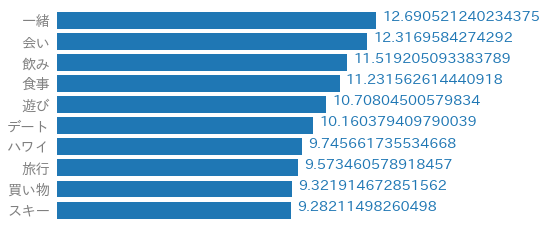

In [103]:
import japanize_matplotlib 
#pycoolplot.horizontal_bar(words.reverse(), data.reverse())
words.reverse()
data.reverse()
pycoolplot.horizontal_bar(words, data)
pycoolplot.plt.show()